In [1]:
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import time
import torch.optim as optim
import torch.nn.functional as F
from functools import reduce
from sklearn.metrics import r2_score as R2

from gru import *

import warnings
warnings.filterwarnings('ignore')

### Knowledge guided machine learning implementation using gated recurrent units
### Inspired from https://gmd.copernicus.org/articles/15/2839/2022

In [2]:
target = 'NEE'

model = ['rcef_RandomForestRegressor', 'rcef_RidgeCV', 'rcef_XGBRegressor', 'xgboost'] 

extracted_features = model[-1]

In [3]:
xgbFeatImp = pd.read_csv('feature_analysis/xgboost/FeaturesImportance'  + target  + 'weather_soil_data' + '.csv')
feat_cols = []
for i in range(len(xgbFeatImp.values)):
    feat_cols.append(xgbFeatImp.values[i][0])

observed_df = pd.read_csv('datasets/TestTrainextractedNEE_CUT_REF_NIGHTobsfeats.csv')

observed_df['initial planting density (m-2)1'] = 8.2

x_observed = observed_df[feat_cols]
y_observed = observed_df['NEE']

for entr in x_observed.columns:
    x_observed[entr] = preprocessing.normalize([x_observed[entr]])[0]
y_observed = pd.Series(preprocessing.normalize([y_observed])[0], name='NEE')

# 0.70 train , 0.15 val , 0.25 test

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(
   x_observed, y_observed, test_size=0.25, random_state=41)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.15, random_state=41) #0.70 , 0.15 x 2

In [5]:
# define what optimizer to use
opt_name = 'adam'

compute_r2=R2Loss()
n_a=64 #hidden state number
n_l=4 #layer of lstm
nout1=1
nout2=1
dropout=0.2
path_save = 'kgml-results/' + opt_name
save_file = '/gru_fine_tune_relu'
mds_file = '/stats_fine_tune_relu'
os.makedirs(path_save, exist_ok=True)  
model1=KGML(len(feat_cols),n_a,n_l,1,dropout)

checkpoint=torch.load(path_save + '/gru-pre_train')
model1.load_state_dict(checkpoint['model_state_dict'])

print("Model's state_dict:")
#model1.to(device)
print(model1)
params = list(model1.parameters())
print(len(params))
print(params[5].size())  # conv1's .weight
model_save = path_save + save_file
stats_save = path_save + mds_file

Model's state_dict:
KGML(
  (gru): GRU(11, 64, num_layers=4, dropout=0.2)
  (densor2): Linear(in_features=64, out_features=1, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)
18
torch.Size([192, 64])


In [6]:
def get_optimizer_with_scheduler(opt_name: str) -> list:
    opt, sch = 0,0
    if opt_name == 'adam':
        opt = optim.Adam(model1.parameters(), lr=0.0001)
        sch = optim.lr_scheduler.StepLR(opt, step_size=600, gamma=0.5)
    
    elif opt_name == 'sgd':
        opt =  optim.SGD(model1.parameters(), lr=0.1)
        sch = optim.lr_scheduler.StepLR(opt, step_size=600, gamma=1)

    elif opt_name == 'adagrad':
    
        opt = optim.Adagrad(model1.parameters(), lr=0.01)
        #adagrad has no weight decay strategy
        sch = optim.lr_scheduler.StepLR(opt, step_size=600)
    
    elif opt_name == 'rmsprop':
        opt = optim.RMSprop(model1.parameters(), lr=0.001)
        sch = optim.lr_scheduler.StepLR(opt, step_size=600, gamma=0.9)
    
    return opt, sch

optimizer, scheduler =  get_optimizer_with_scheduler(opt_name)

In [7]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

### Batch size needs to be changed to be a divisor of the training data

In [ ]:
starttime=time.time()
loss_val_best = 500000
batch_total=X_train.shape[0]
batch_size=158  # this is the batch size for training
#during validation
train_losses = []
val_losses = []
R2_best=-2
early_stopping = EarlyStopping(tolerance=5, min_delta=0.001)


batches = int(batch_total/batch_size)

#turn pd df to pytorch tensors
X_train_torch = torch.tensor(X_train.values)
Y_train_torch = torch.tensor(Y_train.values)
X_train_torch = X_train_torch.view(batches, batch_size, 11)
Y_train_torch = Y_train_torch.view(batches, batch_size, 1)

X_val_torch = torch.tensor(X_val.values)
Y_val_torch = torch.tensor(Y_val.values)

X_val_torch = X_val_torch.view(1, X_val_torch.size(0), X_val_torch.size(1))
Y_val_torch = Y_val_torch.view(Y_val_torch.size(0), 1, 1)

maxepoch=3000

model1.train()
for epoch in range(maxepoch):
    
    train_loss=0.0
    val_loss=0.0
    model1.zero_grad()
    
    
    Y_pred_all= torch.zeros(Y_train_torch.shape)
    
    for bb in range(int(batch_total/batch_size)):
        
        hidden = model1.init_hidden(batch_size)
        
        hidden = hidden.float()
    
        Y_pred,hidden = model1(X_train_torch[bb:bb+1, :].float(),\
                                hidden)
        
        loss = my_loss(Y_pred, Y_train_torch[bb:(bb+1),:])
        for nh in range(len(hidden[0])):
            hidden[0][nh].detach()
        hidden[1].detach()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            train_loss=train_loss+loss.item()
            Y_pred_all[bb:(bb+1),:]=Y_pred[:,:]
    scheduler.step()
    
    #validation
    model1.eval()
    with torch.no_grad():
        train_loss=train_loss/(batch_total/batch_size)
        train_losses.append(train_loss)
        train_R2=compute_r2(Y_pred_all[:,0].contiguous().view(-1),Y_train_torch[:,0].contiguous().view(-1)).item()
        Y_val_pred=torch.zeros(Y_train_torch.size())
        
        hidden = model1.init_hidden(X_val_torch.size(1))   
        Y_val_pred, hidden = model1(X_val_torch.float(), hidden)
        loss = my_loss(Y_val_pred, Y_val_torch)
        val_loss=loss.item()
        val_losses.append(val_loss)
        val_R2=compute_r2(Y_val_pred[:,:,0].contiguous().view(-1),Y_val_torch[:,:,0].contiguous().view(-1)).item()
        if val_loss < loss_val_best and val_R2 > R2_best:
            loss_val_best=val_loss
            R2_best = val_R2
            
            f0=open(model_save,'w')
            f0.close()
            #os.remove(path_save)
            torch.save({'epoch': epoch,
                    'model_state_dict': model1.state_dict(),
                    'R2': train_R2,
                    'loss': train_loss,
                    'los_val': val_loss,
                    'R2_val': val_R2,
                    }, model_save)
            
        
        early_stopping(train_loss, val_loss)    
        if early_stopping.early_stop:
            print("Early stopped at epoch:", epoch+1)
            break
        
        print("finished training epoch", epoch+1)
    mtime=time.time()
    print("train_loss: ", train_loss, "train_R2", train_R2)

    if train_R2 > 0.99:
        break
    model1.train()
endtime=time.time()
torch.save({'train_losses': train_losses,
            'val_losses': val_losses,
            'model_state_dict_fs': model1.state_dict(),
            }, stats_save)  
print("final train_loss:",train_loss,"final train_R2:",train_R2,"val_loss:",val_loss,"loss validation best:",loss_val_best)
print(f"total Training time: {endtime - starttime}s")

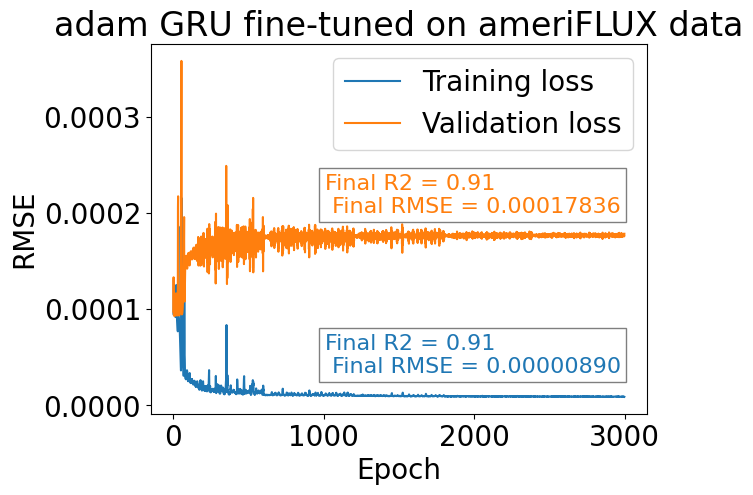

In [13]:
checkpoint=torch.load(stats_save)
train_losses=checkpoint['train_losses']
val_losses=checkpoint['val_losses']
plt.rcParams.update({'font.size': 20})
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
fig= plt.plot(figsize=(6, 10)) 
train_line, = plt.plot(train_losses, label="Training loss") 
val_line, = plt.plot(val_losses, label="Validation loss")
plt.title(opt_name + " GRU fine-tuned on ameriFLUX data")
plt.text(0.35, 0.1, "Final R2 = %0.2f\n Final RMSE = %0.8f" % (train_R2, train_loss), ha="left", va="bottom", color=train_line.get_color(), fontsize=16, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.text(0.35, 0.65, "Final R2 = %0.2f\n Final RMSE = %0.8f" % (val_R2, val_loss), ha="left", va="top", color=val_line.get_color(), fontsize=16, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.legend()

In [27]:
X_test_torch = torch.tensor(X_test.values)
Y_test_torch = torch.tensor(Y_test.values)

X_test_torch = X_test_torch.view(1, X_test_torch.size(0), X_test_torch.size(1))
Y_test_torch = Y_test_torch.view(Y_test_torch.size(0), 1, 1)
test_losses=[]
test_loss=[] 

with torch.no_grad():
    hidden = model1.init_hidden(X_test_torch.size(1))   

    hidden = hidden.float()
    
    Y_test_pred, hidden = model1(X_test_torch.float())
    
    loss = my_loss(Y_test_pred, Y_test_torch)
    
    test_R2=compute_r2(Y_test_pred[:,:,0].contiguous().view(-1),Y_test_torch[:,:,0].contiguous().view(-1)).item()

RMSE :  0.002754


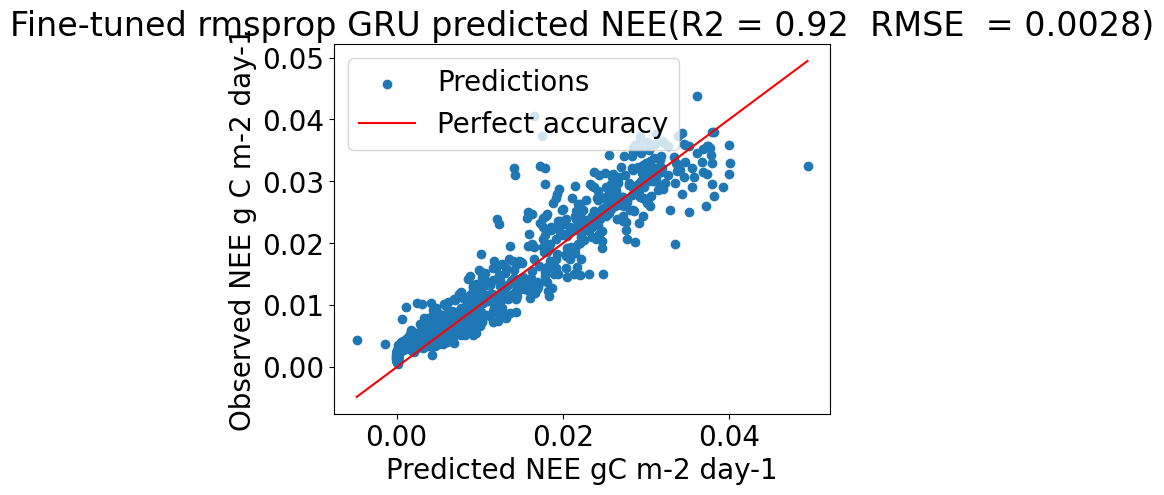

In [28]:
# Calculate R2 score

obs_flatten = Y_test_torch.flatten()
predicted_flatten = Y_test_pred.flatten()

r2 = R2(obs_flatten, predicted_flatten)

rmse = np.sqrt(MSE(obs_flatten, predicted_flatten))
print("RMSE : % f" %(rmse))

# Create scatter plot
plt.scatter(obs_flatten, predicted_flatten)

# Plot a red line for perfect accuracy
x = np.linspace(min(obs_flatten), max(obs_flatten), 100)
plt.plot(x, x, color='r')

# Add title and legend
plt.title("Fine-tuned " + opt_name + " GRU predicted " + target +  "(R2 = %0.2f  RMSE  = %0.4f)" %  (r2, rmse))
plt.legend(['Predictions', 'Perfect accuracy'], loc='upper left')
plt.xlabel("Predicted NEE gC m-2 day-1")
plt.ylabel("Observed NEE g C m-2 day-1")

#plt.savefig("results/bayesian pretrained, grid search fine tuned xgb model  " + target + "with planting details.png" )
# Show plot
plt.show()